# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import random
from collections import namedtuple, deque

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [3]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



(100, 1) (100, 1)


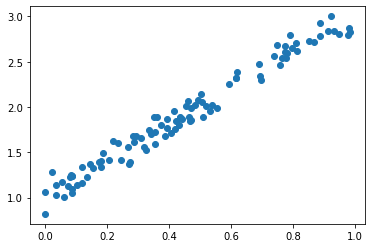

In [90]:
import math
import time

device = 'cuda:0'
torch.manual_seed(42)

N = 100
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(N, 1)

print(x.shape, y.shape)
plt.scatter(x, y)

In [91]:
train_index = math.floor(N * .8)
x_train, y_train = x[:train_index], y[:train_index]
x_validation, y_validation = x[train_index:], y[train_index:]

# Create tensor from numpy
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

x_validation_tensor = torch.from_numpy(x_validation).float().to(device)
y_validation_tensor = torch.from_numpy(y_validation).float().to(device)

In [95]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [96]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
train_data = TensorDataset(x_train_tensor, y_train_tensor)


0.194019, 0.139138


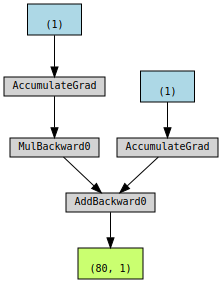

In [27]:
import torchviz

device = 'cuda:0'
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

x_validation_tensor = torch.from_numpy(x_validation).float().to(device)
y_validation_tensor = torch.from_numpy(y_validation).float().to(device)


a_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print("%f, %f" % (a_tensor, b_tensor))
n_epoch = 500

q = deque(maxlen=n_epoch)

y_hat_tensor = b_tensor * x_train_tensor + a_tensor
torchviz.make_dot(y_hat_tensor)

In [28]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step

In [38]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        return self.a + self.b * x
    

In [42]:
lr = .2
n_epochs = 500
show_every = 50
data_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

model = MyModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_step = make_train_step(model, loss_fn, optimizer)
for i in range(n_epoch):
    loss = train_step(x_train_tensor , y_train_tensor)
    if i % show_every == 0:
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, model.a, model.b))



i: 0, loss: 0.198674, a: 1.45, b: 0.77
i: 50, loss: 0.019271, a: 1.15, b: 1.68
i: 100, loss: 0.010625, a: 1.03, b: 1.92
i: 150, loss: 0.009916, a: 1.00, b: 1.99
i: 200, loss: 0.009857, a: 0.99, b: 2.01
i: 250, loss: 0.009853, a: 0.98, b: 2.02
i: 300, loss: 0.009852, a: 0.98, b: 2.02
i: 350, loss: 0.009852, a: 0.98, b: 2.02
i: 400, loss: 0.009852, a: 0.98, b: 2.02
i: 450, loss: 0.009852, a: 0.98, b: 2.02


In [102]:
lr = .2
n_epochs = 500
show_every = 50

model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
train_step = make_train_step(model, loss_fn, optimizer)
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

for i in range(n_epoch):
    loss = train_step(x_train_tensor , y_train_tensor)
    if i % show_every == 0:
        params = list(model.parameters())
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, params[0].item(), params[1].item()))



i: 0, loss: 4.068635, a: 0.80, b: 0.56
i: 50, loss: 0.013029, a: 1.80, b: 1.11
i: 100, loss: 0.009391, a: 1.96, b: 1.04
i: 150, loss: 0.009139, a: 2.00, b: 1.02
i: 200, loss: 0.009120, a: 2.01, b: 1.01
i: 250, loss: 0.009119, a: 2.02, b: 1.01
i: 300, loss: 0.009119, a: 2.02, b: 1.01
i: 350, loss: 0.009119, a: 2.02, b: 1.01
i: 400, loss: 0.009119, a: 2.02, b: 1.01
i: 450, loss: 0.009119, a: 2.02, b: 1.01


i: 0, loss: 0.282125, a: 0.52, b: 1.60
i: 10, loss: 0.024213, a: 1.63, b: 1.18
i: 20, loss: 0.010682, a: 1.93, b: 1.04
i: 30, loss: 0.010064, a: 2.01, b: 1.00
i: 40, loss: 0.010125, a: 2.03, b: 0.99
i: 50, loss: 0.010190, a: 2.04, b: 0.99
i: 60, loss: 0.010204, a: 2.04, b: 0.99
i: 70, loss: 0.010201, a: 2.04, b: 0.99
i: 80, loss: 0.010193, a: 2.04, b: 0.99
i: 90, loss: 0.010200, a: 2.04, b: 0.99
OrderedDict([('0.weight', tensor([[2.0397]], device='cuda:0')), ('0.bias', tensor([0.9895], device='cuda:0'))])


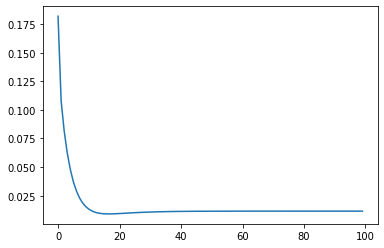

In [113]:
lr = .2
n_epochs = 100
show_every = 10

losses = []
val_losses = []

model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
train_step = make_train_step(model, loss_fn, optimizer)

for i in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    if i % show_every == 0:
        params = list(model.parameters())
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, params[0].item(), params[1].item()))
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
        
# plt.plot(losses)
plt.plot(val_losses)
print(model.state_dict())

In [69]:
optimizer = optim.SGD([a_tensor, b_tensor], lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

for i in range(n_epoch):
    y_hat_tensor = b_tensor * x_train_tensor + a_tensor
    error_tensor = y_train_tensor - y_hat_tensor
    loss_tensor = loss_fn(y_train_tensor, y_hat_tensor)

    loss_tensor.backward()
    optimizer.step()
    optimizer.zero_grad()
    
print("\rloss: %f, a: %.2f, b: %.2f" % (loss_tensor, a_tensor, b_tensor), end='')



loss: 0.008339, a: 1.02, b: 1.95

0.01827177219092846

Validation loss: 0.018272


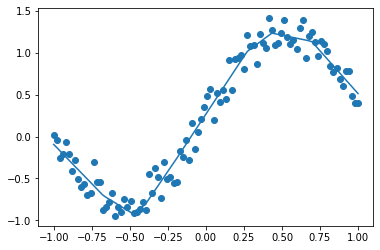

In [178]:
torch.manual_seed(42)

# model = ManualLinearRegression().to(device)
# model = LayerLinearRegression().to(device)
num_hidden = 32
model = nn.Sequential(
    nn.Linear(1, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, 1),
).to(device)

tensor_x = torch.linspace(-1, 1, 100)
x = torch.unsqueeze(tensor_x, dim=1).to(device)
# y = x.pow(2) + 0.2*torch.rand(x.size()).to(device)
y = torch.sin(3 * x) + .5 * torch.rand(x.size()).to(device)

lr = .2
n_epochs = 1000

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for i in range(n_epochs):
    model.train()
    prediction = model(x)
    
    loss = loss_fn(prediction, y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(loss.item())
# print(model.state_dict())
print("\nValidation loss: %f" % loss)

step = 100
xv = np.linspace(-1, 1, step).reshape(step, 1)
xy = model(torch.tensor(xv).float().to(device)).cpu().detach().numpy()
plt.plot(xv, xy)
plt.scatter(x.cpu().detach().numpy(), y.cpu().detach().numpy())

In [121]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [17]:
agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
reward = 0
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [23]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(300):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            print(reward, done)
            break 
    print(reward, done)
            
env.close()

100 True
100 True
1.7546213733868938 False
1.601717784744207 False
-0.5112277870111399 False
0.2836393865500611 False


### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  